## What is the distribution of the energy and gas usage over the day? Are there monthly or seasonal patterns in the energy and gas usage? How to identify time intervals when nobody is at home?

###  Description :
In this report, we analyze the energy and gas usage patterns in a single-family home from September 2022 to April 2023, where electricity and gas usage are collected biweekly with a 15-minute resolution. The report aims to answer three key questions regarding the distribution of energy and gas usage over the day, seasonal and weekly patterns in energy and gas usage, and the identification of time intervals when nobody is at home.

### Data Preparation :
- The dataset includes 3 columns: time, type (electricity or gas), and value (usage value). 

In [2]:
import sys
import os
import ssl
import warnings
warnings.filterwarnings("ignore") # Ignore all warnings
sys.path.append('../')  # Add the parent directory to the system path
ssl._create_default_https_context = ssl._create_unverified_context

# import the dataset 
from tools.openweather import openweather_data
openweather_data=openweather_data.copy()

from tools.home_messages_db  import *
db_url = f'sqlite:///{os.path.join(os.path.dirname(os.getcwd()), "myhome.db")}'
db = home_messages_db(url = db_url)

consumption = db.query_df("SELECT time, type, value FROM Consumption")
consumption["time"] =pd.to_datetime(consumption["time"].astype(int), unit='s', origin='unix')

# we separate electricity and gas consumption
elec_consumption=consumption.loc[consumption.type=="electricity"]
gas_consumption=consumption.loc[consumption.type=="gas"]

consumption

,time,type,value
0,2022-03-18 14:30:00,electricity,0.261
1,2022-03-18 14:45:00,electricity,0.725
2,2022-03-18 15:00:00,electricity,0.559
3,2022-03-18 15:15:00,electricity,0.133
4,2022-03-18 15:30:00,electricity,0.286
...,...,...,...
206788,2023-04-04 21:30:00,gas,0.000
206789,2023-04-04 21:45:00,gas,0.018
206790,2023-04-04 22:00:00,gas,0.054
206791,2023-04-04 22:15:00,gas,0.072


- We made summary statistics for the value column of electricity and gas consumed by the family

In [3]:
# Separate electricity and gas consumption
elec_consumption = consumption[consumption['type'] == 'electricity']
gas_consumption = consumption[consumption['type'] == 'gas']

# Calculate the summary statistics for electricity and gas
electricity_summary = elec_consumption['value'].describe()
gas_summary = gas_consumption['value'].describe()

# Create a new dataframe for storing the summary
summary_df = pd.DataFrame(columns=['Statistic', 'Electricity', 'Gas'])
summary_df['Statistic'] = electricity_summary.index
summary_df['Electricity'] = electricity_summary.values
summary_df['Gas'] = gas_summary.values

# Print the summary dataframe
summary_df

,Statistic,Electricity,Gas
0,count,106668.000000,100125.000000
1,mean,0.104784,0.034693
2,std,0.125320,0.059023
3,min,0.001000,0.000000
4,25%,0.037000,0.000000
5,50%,0.060000,0.010000
6,75%,0.111000,0.053000
7,max,1.432000,0.953000


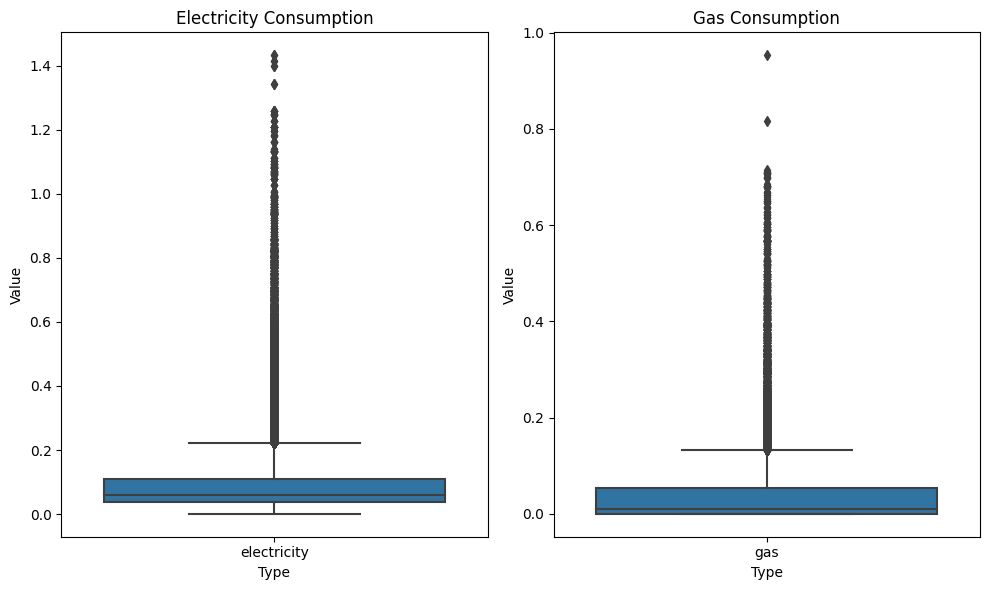

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create subplots for electricity and gas boxplots
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Boxplot for electricity consumption
sns.boxplot(data=elec_consumption, x='type', y='value', ax=axes[0])
axes[0].set_title('Electricity Consumption')
axes[0].set_xlabel('Type')
axes[0].set_ylabel('Value')

# Boxplot for gas consumption
sns.boxplot(data=gas_consumption, x='type', y='value', ax=axes[1])
axes[1].set_title('Gas Consumption')
axes[1].set_xlabel('Type')
axes[1].set_ylabel('Value')

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()

Looking at the boxplot, we can see that there are a lot of unusual outliers for both electric and gas usage. This indicates that the family sometimes used electricity and gas with a relatively high capacity that is much superior (many appliances were used simultaneously).

###  Usage over the day
To identify distribution of electricity and gas usage over the day, we examined the data across different hours of the day. Line plot is generated to visualize the energy consumption patterns throughout the day. We see distinct increases in electricity usage from afternoon and peaks during evening hours, indicating periods of higher energy demand. Gas usage shows similar trends in peak usage.

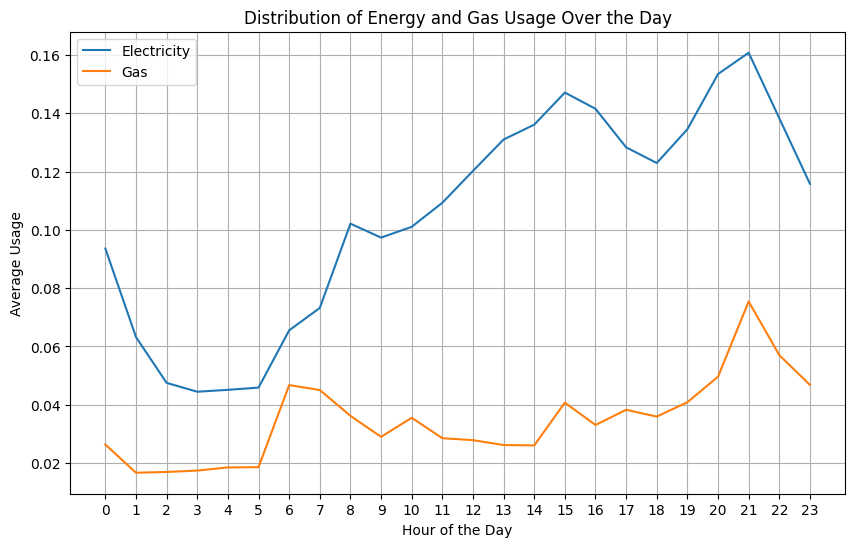

In [5]:
# Group by hour and calculate the average usage
elec_hourly_usage = elec_consumption.groupby(elec_consumption['time'].dt.hour)['value'].mean()
gas_hourly_usage = gas_consumption.groupby(gas_consumption['time'].dt.hour)['value'].mean()

plt.figure(figsize=(10, 6))

# Electricity usage plot
plt.plot(elec_hourly_usage.index, elec_hourly_usage.values, label='Electricity')
# Gas usage plot
plt.plot(gas_hourly_usage.index, gas_hourly_usage.values, label='Gas')

# Customize the plot
plt.title('Distribution of Energy and Gas Usage Over the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Usage')
plt.xticks(range(24))
plt.grid(True)
plt.legend()
plt.show()

### Monthly/ seasonal patterns


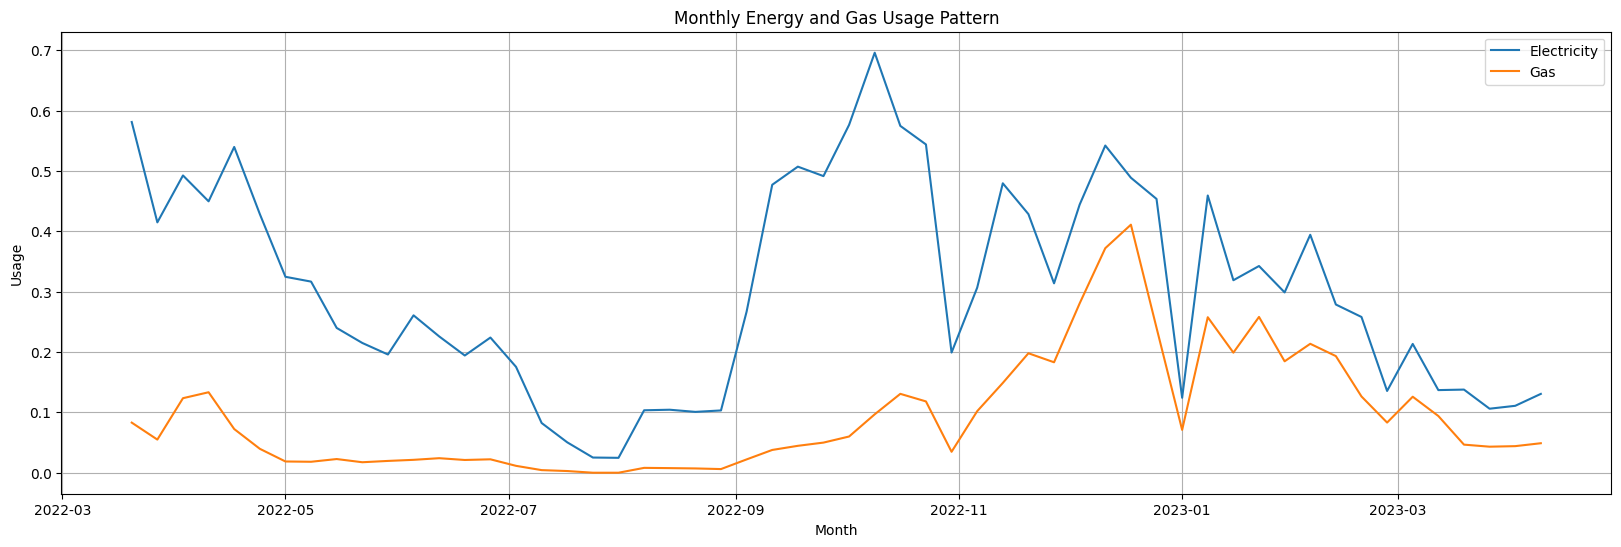

In [6]:
df_agg = consumption.groupby(['time', 'type'])['value'].sum().reset_index()

# Pivot the aggregated dataframe
wide_df = df_agg.pivot(index='time', columns='type', values='value').reset_index()

# Rename the columns
wide_df.columns = ['time', 'electric', 'gas']

# Print the wide dataframe
wide_df.dropna(inplace=True)
wide_df.set_index('time', inplace=True)

weekly_avg = wide_df.resample('W').mean()

# Plot the pattern chart
plt.figure(figsize=(20, 6))
plt.plot(weekly_avg.index, weekly_avg['electric'], label='Electricity')
plt.plot(weekly_avg.index, weekly_avg['gas'], label='Gas')
plt.xlabel('Month')
plt.ylabel('Usage')
plt.title('Monthly Energy and Gas Usage Pattern')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# Resample the data on a daily basis to make plot clearer through each month
total_daily_usage = wide_df.resample('D').sum()
total_daily_usage

,electric,gas
time,,
2022-03-18,28.060,2.754
2022-03-19,51.132,8.188
2022-03-20,54.500,8.156
2022-03-21,31.756,7.570
2022-03-22,32.964,6.258
...,...,...
2023-03-31,10.375,3.287
2023-04-01,17.374,4.972
2023-04-02,12.161,4.588


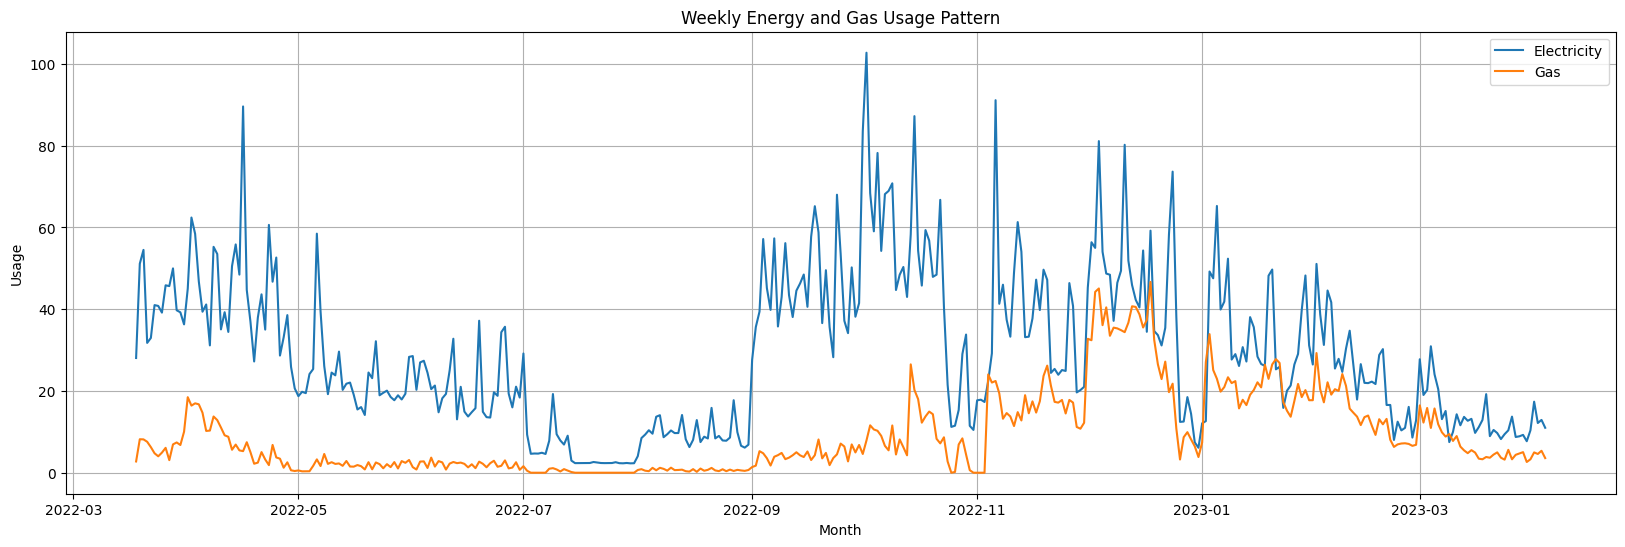

In [8]:
# Plot the weekly pattern chart
plt.figure(figsize=(20, 6))
plt.plot(total_daily_usage.index, total_daily_usage['electric'], label='Electricity')
plt.plot(total_daily_usage.index, total_daily_usage['gas'], label='Gas')
plt.xlabel('Month')
plt.ylabel('Usage')
plt.title('Weekly Energy and Gas Usage Pattern')
plt.legend()
plt.grid(True)
plt.show()

Upon analyzing the monthly chart of electricity consumption, a clear and consistent trend emerges, indicating the seasonality of both electricity and gas usage. Specifically, during the summer period from July to August and from the end of December to January, there is a notable and significant decrease in electricity consumption. This decline can be attributed to various factors such as reduced consumption demand due to weather or travelling in big holidays. In terms of gas consumption, a similar seasonal pattern is observed, with a decrease and sustained low levels of consumption from late April to mid-October. However, starting from mid-November through early April, gas consumption experiences a sharp and substantial increase. This surge in consumption can be attributed to the heightened need for heating during the colder winter months. These monthly patterns highlight the impact of seasonal variations on both electricity and gas usage, emphasizing the importance of considering seasonality in energy planning and management.

### Check if nobody is at home

We consider periods with minimal or no activity as potential time intervals when nobody is at home. After excluding sleeping time, the results indicated specific time ranges, such as weekdays from 9 AM to 8 PM, when the house is likely unoccupied, a possible reason being that the occupants are away for work.


In [9]:
consumption['time'] = pd.to_datetime(consumption['time'])

# Filter the data to exclude the time interval from 22:00:00 to 08:00:00 (considered as sleeping time)
filtered_consumption = consumption[~((consumption['time'].dt.hour >= 22) | (consumption['time'].dt.hour <= 8))]
filtered_consumption['time'] = pd.to_datetime(filtered_consumption['time'])
filtered_consumption.set_index('time', inplace=True)

threshold = 0.1  # Define a threshold value for energy consumption

# Identify the time intervals
nobody_home_intervals = []
current_interval_start = None
for index, row in filtered_consumption.iterrows():
    if row['value'] < threshold:
        if current_interval_start is None:
            current_interval_start = index
    else:
        if current_interval_start is not None:
            current_interval_end = index - pd.Timedelta(minutes=15)
            nobody_home_intervals.append((current_interval_start, current_interval_end))
            current_interval_start = None

# Combine consecutive intervals within a time threshold 
combined_intervals = []
current_interval_start = None
current_interval_end = None
for start_time, end_time in nobody_home_intervals:
    if current_interval_start is None:
        current_interval_start = start_time
        current_interval_end = end_time
    elif start_time - current_interval_end > pd.Timedelta(hours=1):
        combined_intervals.append((current_interval_start, current_interval_end))
        current_interval_start = start_time
        current_interval_end = end_time
    else:
        current_interval_end = end_time
# Add the last combined interval
combined_intervals.append((current_interval_start, current_interval_end))

# Print the identified intervals
for start_time, end_time in combined_intervals:
    print(f"Considered to be nobody at home from {start_time} to {end_time}")


Considered to be nobody at home from 2022-03-18 15:45:00 to 2022-03-18 18:45:00
Considered to be nobody at home from 2022-03-19 09:45:00 to 2022-03-19 12:45:00
Considered to be nobody at home from 2022-03-19 15:15:00 to 2022-03-19 19:15:00
Considered to be nobody at home from 2022-03-19 21:45:00 to 2022-03-20 11:15:00
Considered to be nobody at home from 2022-03-20 15:00:00 to 2022-03-22 21:30:00
Considered to be nobody at home from 2022-03-23 09:00:00 to 2022-03-23 20:15:00
Considered to be nobody at home from 2022-03-24 09:15:00 to 2022-03-24 21:00:00
Considered to be nobody at home from 2022-03-25 09:00:00 to 2022-03-25 13:30:00
Considered to be nobody at home from 2022-03-25 15:00:00 to 2022-03-25 21:00:00
Considered to be nobody at home from 2022-03-26 09:00:00 to 2022-03-26 14:00:00
Considered to be nobody at home from 2022-03-26 16:00:00 to 2022-03-26 18:30:00
Considered to be nobody at home from 2022-03-26 20:45:00 to 2022-03-27 11:30:00
Considered to be nobody at home from 202